In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from scipy.special import boxcox1p
from scipy import stats
from scipy.stats import norm, normaltest, boxcox_normmax
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

# Global Functions

Reduce Memory usage function from [ASHRAE](https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction#5.-Reducing-Memory-Size)

In [2]:
def build_encoder_pipe(model, features):
    # Label encode categorical columns

    cat_cols = []
    for i,col in enumerate(features.columns):
        if pd.api.types.is_categorical_dtype(features[col]):
            cat_cols.append(i)

    # Column Transformer
    ct = ColumnTransformer(
        [('labeler', LabelEncoder(), cat_cols)],
        remainder='passthrough'
    )
    return Pipeline(
        [("transf", ct),
         ("estimator", model)]
    )

In [3]:
def label_encode(features, encoders={}):
    for col in features.columns:
        if pd.api.types.is_categorical_dtype(features[col]):
            if col in encoders.keys():
                features[col] = encoders[col].transform(features[col])
            else:
                enc = LabelEncoder()
                enc.fit(features[col])
                encoders[col] = enc
                features[col] = enc.transform(features[col])
    return features, encoders

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [6]:
def val_dist(pred, target):
    trace = go.Box(y=np.exp(pred),
                   boxpoints='all',
                   jitter=0.3,
                   pointpos=-1.8,
                   name="Validation Predictions"
                  )

    trace2 = go.Box(y=np.exp(target),
                    boxpoints='all',
                    jitter=0.3,
                    pointpos=-1.8,
                    name="Validation Targets"
                   )

    layout = go.Layout(
        title="Validation Prediction Distribution",
        height=800
    )

    fig = go.Figure(data=[trace, trace2], layout=layout)

    iplot(fig)

## Data Load and Type Resolution

In [7]:
house_train = pd.read_csv("../data/train.csv")
house_test = pd.read_csv("../data/test.csv")
sorted(house_train.columns)

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'Alley',
 'BedroomAbvGr',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'EnclosedPorch',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Fireplaces',
 'Foundation',
 'FullBath',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'Id',
 'KitchenAbvGr',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotArea',
 'LotConfig',
 'LotFrontage',
 'LotShape',
 'LowQualFinSF',
 'MSSubClass',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'Neighborhood',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PavedDrive',
 'PoolArea',
 'PoolQC',
 'RoofMatl',
 'RoofStyle

In [8]:
response = 'SalePrice'

Don't need Id column for training

In [9]:
house_train = reduce_mem_usage(house_train)
house_test = reduce_mem_usage(house_test)

Mem. usage decreased to  0.57 Mb (36.4% reduction)
Mem. usage decreased to  0.57 Mb (35.8% reduction)


Change all object columns to category dtype. From [this post](https://stackoverflow.com/questions/39904889/pandas-cast-all-object-columns-to-category)

In [10]:
house_train = pd.concat([
    house_train.select_dtypes([], ['object']),
    house_train.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
    ], axis=1)

house_test = pd.concat([
    house_test.select_dtypes([], ['object']),
    house_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
    ], axis=1)

Change columns that have numbers for categories to category type columns

In [11]:
num_cats = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold', 'GarageYrBlt']
for col in num_cats:
    house_train[col] = house_train[col].astype('category')
    house_test[col] = house_test[col].astype('category')

## Missing Data

In [12]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [13]:
missing_data(house_train).head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageFinish,81,0.055479


In [14]:
missing_data(house_test).head(20)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageFinish,78,0.053461


### Handle missing values for features where median/mean or most common value doesn't make sense
Notice that the columns that have missing values are all categorical except for `LotFrontage`

Change missing values into 'NA' category since having a missing data point for these categories mean NA

In [15]:
def fill_na(df, col, test=False):
    medians = df.median()
    if df[col].isnull().any():
        if pd.api.types.is_categorical_dtype(df[col]):
            value = 'NA'
            if col in ['Condition1', 'Condition2']:
                value = 'Norm'
            elif col == 'CentralAir':
                value = 'N'
            elif col in ['ExterCond', 'ExterQual', 'HeatingQC', 'KitchenQual']:
                value = 'TA'
            elif col == 'Functional':
                value = 'Typ'
            elif col == 'LotShape':
                value = 'Reg'
            elif col == 'MasVnrType':
                value = 'None'
            elif col == 'SaleCondition':
                value = 'Normal'
            elif col == 'Utilities':
                value = 'AllPub'
            elif col in num_cats:
                if not test:
                    # Drop rows from categorical columns with numbers as they don't have NA category
                    df.drop(df[df[col].isnull()].index, inplace=True)
                    return
                else:
                    value = int(medians[col])
            try:
                df[col].cat.add_categories([value], inplace=True)
            except:
                pass
            finally:
                df[col].fillna(value, inplace=True)
        else:
            df[col].fillna(0, inplace=True)

In [16]:
dont_check_cols = ['Id', response]
check_missing_cols = [col for col in house_train.columns if col not in dont_check_cols]

In [17]:
for col in check_missing_cols:
    fill_na(house_train, col)
    fill_na(house_test, col, test=True)

In [18]:
missing_data(house_train).head(3)

,Total,Percent
SaleCondition,0,0.0
Street,0,0.0
BedroomAbvGr,0,0.0


In [19]:
missing_data(house_test).head(3)

,Total,Percent
SaleCondition,0,0.0
SaleType,0,0.0
BedroomAbvGr,0,0.0


## Some Bivariate Analysis

In [20]:
def one_bivariate_plot(df, column, resp_var, add_plot=None):
    typ = df.dtypes[column]
    if pd.api.types.is_numeric_dtype(typ):
        data = pd.concat([df[resp_var], df[column]], axis=1)
        data.plot.scatter(x=column, y=resp_var, figsize=(10, 8))
    else:
        data = pd.concat([df['SalePrice'], df[column]], axis=1)
        f, ax = plt.subplots(figsize=(10, 8))
        fig = sns.boxplot(x=column, y=resp_var, data=data)
    plt.title(f"{column} vs. {resp_var}")
    plt.xticks(rotation=45)
    if add_plot:
        plt.plot(add_plot)

In [21]:
def bivariate_plots(df, resp_var):
    for col in sorted(df.columns):
        one_bivariate_plot(df, col, resp_var)

for col in house_train.columns:
    if pd.api.types.is_int64_dtype(house_train[col]):
        bivariate_scatter_plot(col)

In [22]:
# bivariate_plots(house_train, response)

In [23]:
plt.close('all')

## Correlation Matrix

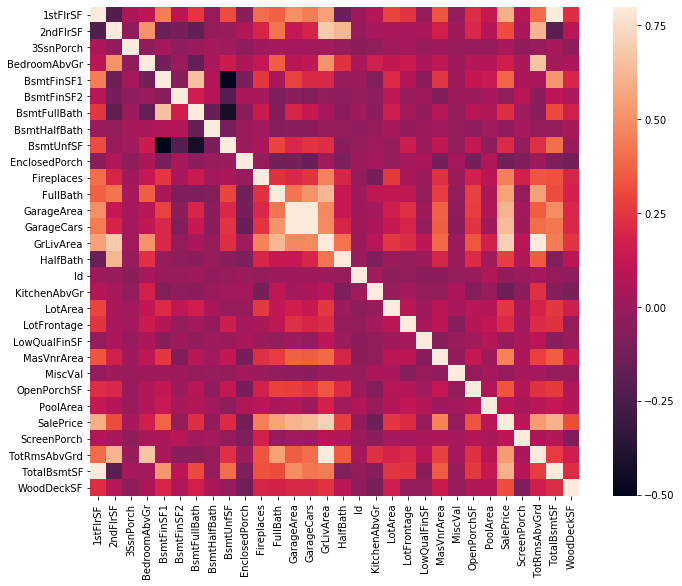

In [24]:
correlation = house_train.corr()
correlation = correlation.reindex(sorted(correlation.columns), axis=1)
correlation.sort_index(inplace=True)

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation, vmax=.8, square=True)

In [25]:
trace = go.Heatmap(
    z = list(reversed(correlation.values.tolist())),
    x = correlation.columns,
    y = correlation.columns[::-1],
    colorscale = 'Viridis',
    zmax = 0.8,
    zmin = -0.5
)

data = [trace]

layout = go.Layout(
    title="Correlation Matrix",
    height=800
)

fig = dict(data=data, layout=layout)
iplot(fig)

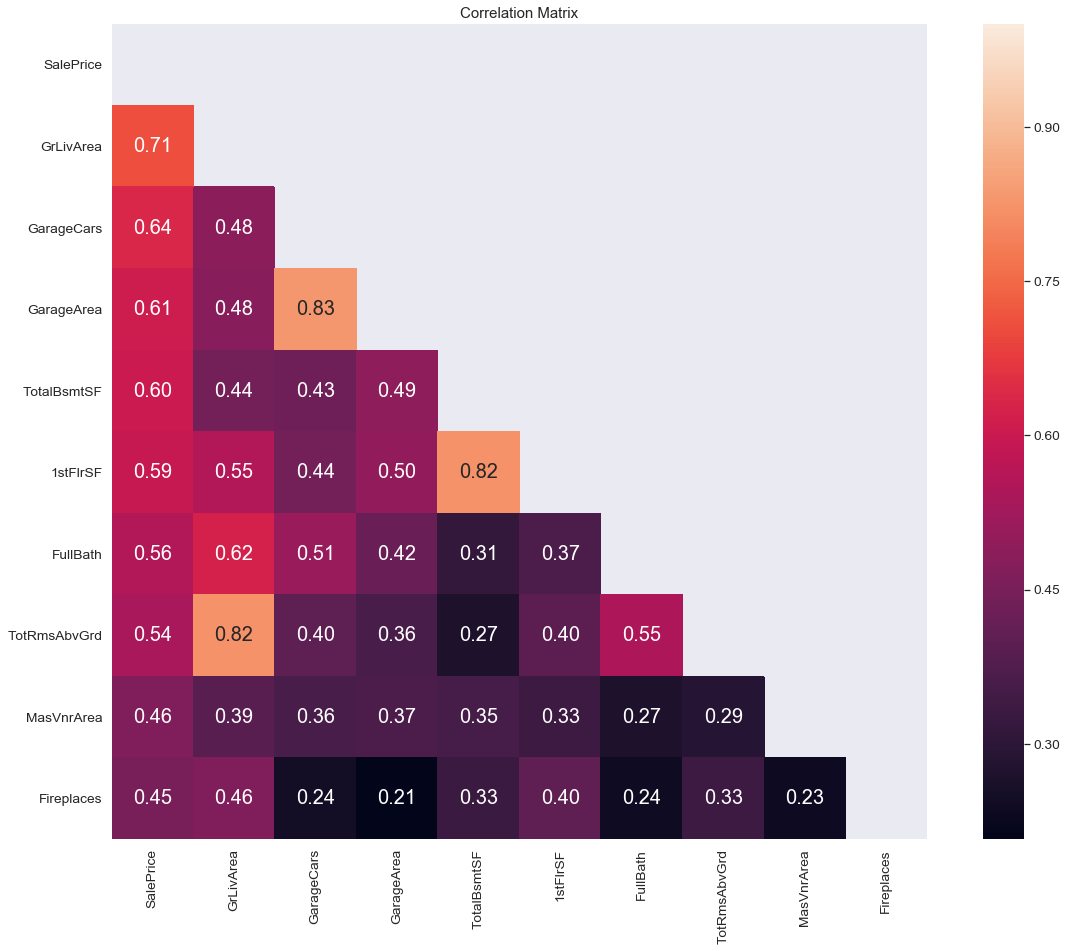

In [26]:
cols = correlation.nlargest(10, response)[response].index
cm = np.corrcoef(house_train[cols].values.T)

mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.25)
fig = plt.figure(figsize=(20,15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', mask=mask,
                 annot_kws={'size': 20}, yticklabels=cols.values, xticklabels=cols.values)

hm.set_title("Correlation Matrix")

plt.show()

In [27]:
fig = ff.create_annotated_heatmap(
    z = list(reversed(np.round(cm, 2))),
    x = cols.values.tolist(),
    y = list(reversed(cols.values.tolist())),

    colorscale = 'Viridis',
    showscale = True,
    hoverinfo = 'skip'
)

fig.update_layout(
    title_text = "Correlation Matrix",
)

fig.update_xaxes(automargin=True)

iplot(fig)

Look at Bivariate plots on the following columns that can possibly be high predictors of Sale Price

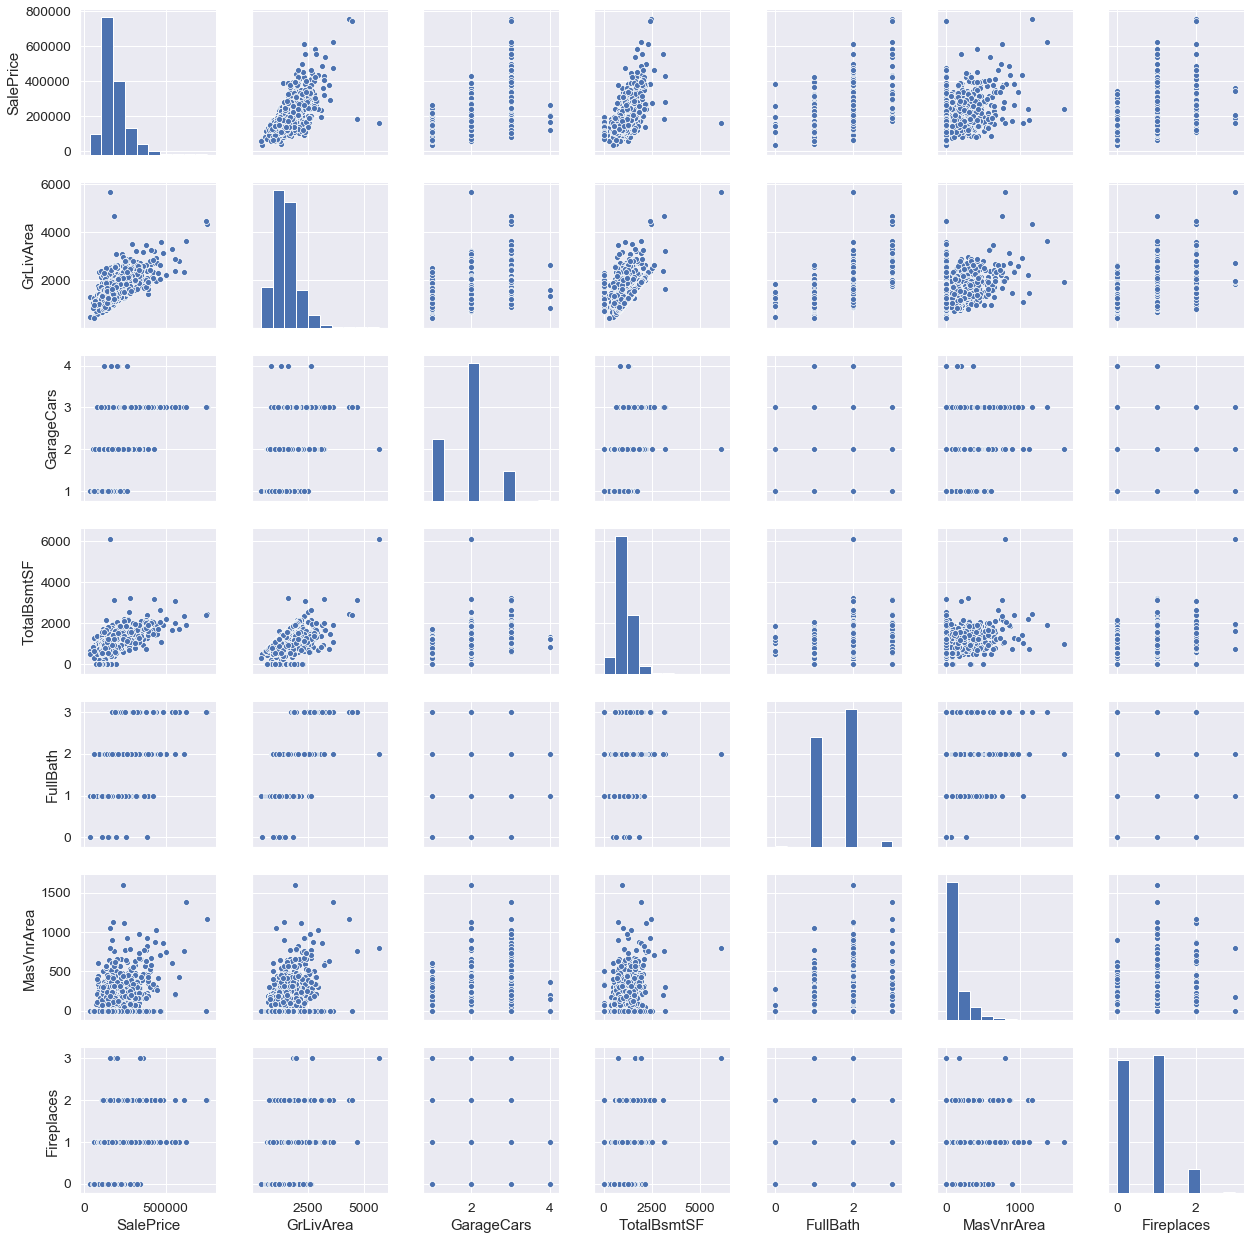

In [28]:
cols = ['SalePrice', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'MasVnrArea', 'Fireplaces']
drop_cols = ['GarageArea', '1stFlrSF','TotRmsAbvGrd']
sns.pairplot(house_train[cols], height = 2.5)

Not as useful as Seaborn's pairplots

In [29]:
fig = px.scatter_matrix(house_train[cols])
iplot(fig)

Drop columns deemed redundant (i.e. high correlation)

In [30]:
house_train.drop(drop_cols, axis=1, inplace=True)
house_test.drop(drop_cols, axis=1, inplace=True)

Grab quantitiative and qualitative features

In [31]:
quantitative = [feat for feat in house_train.columns if pd.api.types.is_numeric_dtype(house_train[feat])]
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [feat for feat in house_train.columns if pd.api.types.is_categorical_dtype(house_train[feat])]

In [32]:
quantitative

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [33]:
qualitative

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'MoSold',
 'YrSold',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

<b>Check that we have all the columns</b><br>
Quantitative + Qualitative + SalePrice and Id

In [34]:
len(quantitative) + len(qualitative) + 2 == len(house_train.columns)

True

## Exploring Response Variable 'SalePrice'

In [35]:
house_train.SalePrice.describe()

count      1379.00000
mean     185479.51124
std       79023.89060
min       35311.00000
25%      134000.00000
50%      167500.00000
75%      217750.00000
max      755000.00000
Name: SalePrice, dtype: float64

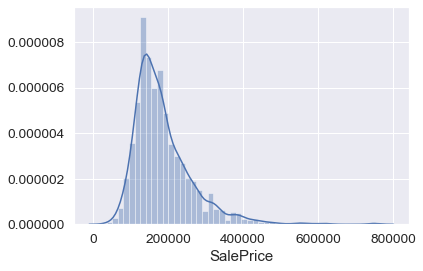

In [36]:
sns.distplot(house_train.SalePrice)

* Not Normally distributed
* Positive Skewness
* Shows peakedness

In [37]:
print(f"Skewness: {round(house_train.SalePrice.skew(), 3)}")
print(f"Kurtosis: {round(house_train.SalePrice.kurt(), 3)}")

Skewness: 1.935
Kurtosis: 6.736


Log Transform response variable to normalize

Skewness: 0.29
Kurtosis: 0.686


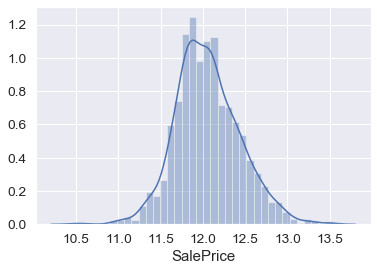

In [38]:
house_train[response] = np.log(house_train[response])

sns.distplot(house_train.SalePrice)
print(f"Skewness: {round(house_train.SalePrice.skew(), 3)}")
print(f"Kurtosis: {round(house_train.SalePrice.kurt(), 3)}")

Deal with outliers

In [39]:
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    indexes = []
    for col in quantitative + [response]:
        outlier_indexes = df[col][(df[col] < (Q1[col] - 1.5 * IQR[col]))\
                                  | (df[col] > (Q3[col] + 1.5 * IQR[col]))]\
            .nlargest(1).index
        indexes = np.append(indexes, outlier_indexes)
        
    pct_removed = round((len(np.unique(indexes)) / len(house_train)) * 100, 2)
    df.drop(indexes, inplace=True)
    print(f"# of Outliers: {len(np.unique(indexes))}")
    print(f"% of Total removed: {pct_removed}%")

In [40]:
remove_outliers(house_train)

# of Outliers: 20
% of Total removed: 1.45%


## Fixing Skewness

In [41]:
house_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD,Abnorml
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [42]:
def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    new_df = df.copy()

    # Check the skew of all numerical features
    skewed_feats = new_df[quantitative].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        new_df[feat] = boxcox1p(new_df[feat], boxcox_normmax(new_df[feat] + 1))
        
    return new_df
        
linear_train = fixing_skewness(house_train)
linear_test = fixing_skewness(house_test)

In [43]:
linear_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1,60,65.0,10.270000,7,5,2003,2003,21.133139,206.991730,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,2,20,80.0,10.434026,6,8,1976,1976,0.000000,266.741981,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,3,60,68.0,10.638722,7,5,2001,2002,19.252766,154.740731,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
3,4,70,60.0,10.427302,7,5,1915,1970,0.000000,82.113286,...,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD,Abnorml
4,5,60,84.0,10.946393,8,5,2000,2000,27.942017,195.252487,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


### One-Hot Encoding for Linear Models

In [44]:
len_train = len(linear_train)
all_data = pd.concat([linear_train.drop(response, axis=1), linear_test], sort=False)

all_data = pd.concat([
    all_data.select_dtypes([], ['object']),
    all_data.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
    ], axis=1)

for col in num_cats:
    all_data[col] = all_data[col].astype('category')
    
all_data_ohe = pd.get_dummies(all_data)

train_ohe, test_ohe = all_data_ohe.iloc[:len_train, :], all_data_ohe.iloc[len_train:, :]

In [45]:
linear_train = train_ohe.drop('Id', axis=1).copy()
linear_test = test_ohe.drop('Id', axis=1).copy()

linear_test.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_NA,SaleType_New,SaleType_Oth,SaleType_WD
0,80.0,50.728202,0.000000,86.944466,7.403284,42.300690,367.449982,0.000000,0.0,6.223738,...,0,0,0,0,0,0,0,0,0,1
1,81.0,54.118585,14.471523,137.029541,0.000000,53.961391,520.266235,0.000000,0.0,6.551188,...,0,0,0,0,0,0,0,0,0,1
2,74.0,53.590856,0.000000,123.596191,0.000000,28.085503,383.646057,666.000314,0.0,6.718956,...,0,0,0,0,0,0,0,0,0,1
3,78.0,48.336775,6.114138,102.946342,0.000000,47.173794,382.944458,644.344768,0.0,6.706239,...,0,0,0,0,0,0,0,0,0,1
4,43.0,38.773083,0.000000,58.967327,0.000000,92.848228,503.953705,0.000000,0.0,6.520127,...,0,0,0,0,0,0,0,0,0,1


### Label Encoding for Tree Models

In [46]:
def label_encode(data, encoders={}):
    for col in data.columns:
        if pd.api.types.is_categorical_dtype(data[col]):
            if col in encoders.keys():
                data[col] = encoders[col].transform(data[col])
            else:
                enc = LabelEncoder()
                enc.fit(data[col])
                encoders[col] = enc
                data[col] = enc.transform(data[col])
    return data, encoders

In [47]:
labeled_data, train_encs = label_encode(all_data)

train_labeled, test_labeled = labeled_data.iloc[:len_train, :], labeled_data.iloc[len_train:, :]

In [48]:
tree_train = train_labeled.drop('Id', axis=1).copy()
tree_test = test_labeled.drop('Id', axis=1).copy()

tree_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior2nd,Heating,Electrical,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,MiscFeature,SaleType
0,5,65.0,10.270000,6,4,106,53,21.133139,206.991730,0.0,...,14,1,5,1,2,5,5,3,1,9
1,0,80.0,10.434026,5,7,79,26,0.000000,266.741981,0.0,...,8,1,5,1,2,5,5,3,1,9
2,5,68.0,10.638722,6,4,104,52,19.252766,154.740731,0.0,...,14,1,5,1,2,5,5,3,1,9
3,6,60.0,10.427302,6,4,21,20,0.000000,82.113286,0.0,...,16,1,5,5,3,5,5,3,1,9
4,5,84.0,10.946393,7,4,103,50,27.942017,195.252487,0.0,...,14,1,5,1,2,5,5,3,1,9


In [49]:
submission = pd.read_csv("../Submissions/sample_submission.csv")

# Baseline to Beat

In [50]:
## Calculating Mean Squared Log Error(MSLE) for only guessing the mean SalePrice
house_train['mean_sale_price'] = house_train.SalePrice.mean()
house_train['msle'] = np.square(house_train.mean_sale_price - house_train.SalePrice)

## getting mse
print("Mean Squared Log Error(MSLE) for average line is : {}".format(house_train.msle.mean()))
print("Root Mean Squared Log Error(RMSLE) for average line is : {}".format(np.sqrt(house_train.msle.mean())))

del house_train['mean_sale_price']
del house_train['msle']

Mean Squared Log Error(MSLE) for average line is : 0.14009977015841105
Root Mean Squared Log Error(RMSLE) for average line is : 0.37429903841502327


# Save Notebook

In [51]:
import dill
dill.dump_session('../Notebook_Saves/preprocess.db')